In [1]:
from EDA_preprocessing import preprocess_data

corrected = "./data/corrected"
kddcup_data = "./data/kddcup.data"

kddcup_data_10_percent_corrected = "./data/kddcup.data_10_percent_corrected"
kddcup_newtestdata_10_percent_unlabeled = "./data/kddcup.newtestdata_10_percent_unlabeled"

kddcup_testdata_unlabeled = "./data/kddcup.testdata.unlabeled"
kddcup_testdata_unlabeled_10_percent = "./data/kddcup.testdata.unlabeled_10_percent"

correspondence = "./data/training_attack_types.txt"

In [2]:
X_train, y_train, X_test, y_test = preprocess_data(kddcup_data,
                                                   kddcup_testdata_unlabeled_10_percent,
                                                   "./data/headers",
                                                   "./data/training_attack_types.txt")

C:\Users\kopoden\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
X_train_matrix = X_train.as_matrix()
X_test_matrix = X_test.as_matrix()

In [4]:
y_train_vector = y_train.as_matrix()
y_test_vector = y_test.as_matrix()

# Model 1

In [170]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras import losses

batch_size = 5000
epochs = 25
learning_rate = 0.001

model = Sequential()
model.add(Dense(64, input_shape=(1, X_train_matrix.shape[1])))
model.add(Dense(128))
model.add(Dropout(0.7))
model.add(Dense(5, activation='softmax'))

In [171]:
y_train_1 = (np.arange(5) == y_train_vector[:,None]).astype(np.int).reshape(-1, 1, 5)
y_test_1 = (np.arange(5) == y_test_vector[:,None]).astype(np.int).reshape(-1, 1, 5)

In [172]:
y_train_1.shape

(827736, 1, 5)

In [173]:
from keras import backend as K
K.set_epsilon(1e-5)

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall))

adam = optimizers.Adam(lr=learning_rate)
sgd  = optimizers.SGD(lr=learning_rate)
model.compile(loss=losses.mean_squared_error,
              optimizer=adam,
              metrics=['accuracy', f1])

In [174]:
history = model.fit(np.reshape(X_train_matrix, (-1, 1, 37)), y_train_1, batch_size=batch_size,
                    validation_data=(np.reshape(X_test_matrix, (-1, 1, 37)), y_test_1), epochs=epochs)#, verbose=False)

Train on 827736 samples, validate on 247247 samples
Epoch 1/25
827736/827736 [==============================] - 5s - loss: 0.0152 - acc: 0.9538 - f1: 0.9388 - val_loss: 0.0058 - val_acc: 0.9831 - val_f1: 0.9832
Epoch 2/25
827736/827736 [==============================] - 3s - loss: 0.0046 - acc: 0.9881 - f1: 0.9882 - val_loss: 0.0038 - val_acc: 0.9900 - val_f1: 0.9900
Epoch 3/25
827736/827736 [==============================] - 3s - loss: 0.0039 - acc: 0.9899 - f1: 0.9899 - val_loss: 0.0037 - val_acc: 0.9904 - val_f1: 0.9904
Epoch 4/25
827736/827736 [==============================] - 3s - loss: 0.0038 - acc: 0.9903 - f1: 0.9902 - val_loss: 0.0036 - val_acc: 0.9907 - val_f1: 0.9907
Epoch 5/25
827736/827736 [==============================] - 4s - loss: 0.0037 - acc: 0.9905 - f1: 0.9905 - val_loss: 0.0035 - val_acc: 0.9909 - val_f1: 0.9909
Epoch 6/25
827736/827736 [==============================] - 3s - loss: 0.0036 - acc: 0.9907 - f1: 0.9907 - val_loss: 0.0035 - val_acc: 0.9908 - val_f1: 0

In [175]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_f1', 'loss', 'acc', 'f1'])


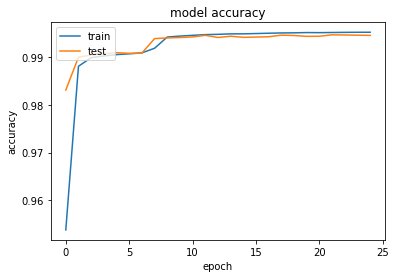

In [176]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

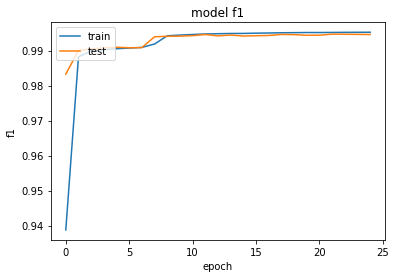

In [177]:
import matplotlib.pyplot as plt
# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

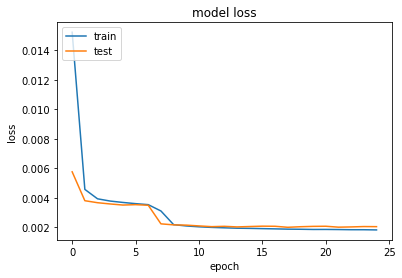

In [178]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 2. 